# Solving the equation:
# $ u_t - u_{xx} + e^{-t}(sin(\pi x) - \pi ^ 2 sin(\pi x)) = 0 $
* # $ x \in [-1, 1] $
* # $ t \in [0, 1] $

# 1. Initial condtion:
# $u(x, 0) = sin(\pi x)$

# 2. Boundary conditions:
* # $u(-1, t) = 0$
* # $u(1, t) = 0$

# Exact solution
# $ u(x, t) = e^{-t}sin(\pi x) $

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from torch.optim.lr_scheduler import ReduceLROnPlateau
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

# Helpers

In [2]:
def plot3D(x,t,y):
  x_plot =x.squeeze(1)
  t_plot =t.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y
  fig,ax=plt.subplots(1,1)
  cp = ax.contourf(T,X, F_xt,20,cmap="rainbow")
  fig.colorbar(cp) # Add a colorbar to a plot
  ax.set_title('F(x,t)')
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  plt.show()
  ax = plt.axes(projection='3d')
  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(),cmap="rainbow")
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [3]:
def plot3D_2(x1, t1, y1, x2, t2, y2):
  fig = plt.figure(figsize=(30, 10))
  ax = fig.add_subplot(111, projection='3d')

  x_plot =x1.squeeze(1)
  t_plot =t1.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y1

  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(), cmap="viridis", label='real')

  x_plot =x2.squeeze(1)
  t_plot =t2.squeeze(1)
  X,T= torch.meshgrid(x_plot,t_plot)
  F_xt = y2

  ax.plot_surface(T.numpy(), X.numpy(), F_xt.numpy(), cmap="rainbow", label='pred')

  legend_elements = [Line2D([0], [0], label='real'), Line2D([0], [0], label='pred')]

  ax.legend(handles=legend_elements)
  ax.set_xlabel('t')
  ax.set_ylabel('x')
  ax.set_zlabel('f(x,t)')
  plt.show()

In [4]:
class FeedForward(nn.Module):
  def __init__(self,
               n_layers,
               layers,
               activation=nn.ReLU()):

    super().__init__()
    self.n_layers = n_layers
    self.layers = layers
    self.activation = activation

    dense_layers = [
        self.dense_layer(in_features=self.layers[i],
                         out_features=self.layers[i+1])
        for i in range(self.n_layers-1)]
    dense_layers.append(nn.Linear(in_features=self.layers[-2],
                                  out_features=self.layers[-1]))

    self.feed_forward = nn.Sequential(*dense_layers)

  def dense_layer(self, in_features, out_features):
    dense_layer = nn.Sequential(
      nn.Linear(in_features=in_features,
                out_features=out_features),
      self.activation,
    )
    return dense_layer

  def forward(self, x):
    return self.feed_forward(x)

In [12]:
class PINN():
  def __init__(self,
               XT, u0, ul, ur,
               layers, n_layers,
               epochs, patience,
               optimizer,
               scheduler, use_scheduler,
               scheduler_p, scheduler_f,
               chkpt_path='model.pth',
               lr=1e-3,
               weight_decay=0,
               activation=nn.ReLU(),
               dtype=torch.float32,
               device='cpu'):

    super().__init__()

    # Some constants
    self.device = device
    self.dtype = dtype
    self.XT = XT
    self.x = torch.tensor(XT[:, 0], dtype=dtype, device=device, requires_grad=True)
    self.t = torch.tensor(XT[:, 1], dtype=dtype, device=device, requires_grad=True)
    self.u0 = torch.tensor(u0, dtype=dtype, device=device)
    self.ul = torch.tensor(ul, dtype=dtype, device=device)
    self.ur = torch.tensor(ur, dtype=dtype, device=device)
    self.epochs = epochs
    self.chkpt_path = chkpt_path
    self.patience = patience

    # Neural network
    self.feed_forward = FeedForward(n_layers=n_layers,
                                    layers=layers,
                                    activation=activation)

    # Setting optimizer and scheduler
    if optimizer == 'Adam':
      self.optimizer = torch.optim.Adam(lr=lr, params=self.feed_forward.parameters(), weight_decay=weight_decay)
    self.use_scheduler = use_scheduler
    if use_scheduler:
      if scheduler == 'ReduceLROnPlateau':
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=scheduler_f, patience=scheduler_p, verbose=True)

  def calculate_u(self, xt):
    return self.feed_forward(xt)

  def calculate_f(self, x, t):
    u = self.calculate_u(torch.cat((x.view(-1, 1), t.view(-1, 1)), dim=1))

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        retain_graph=True,
        create_graph=True
    )[0]

    f_hat = u_t - u_xx + torch.exp(-t) * (1 - torch.pi ** 2) * torch.sin(torch.pi * x)
    # f_hat = u_t + u.squeeze() * u_x.squeeze() - (0.01 / torch.pi)*u_xx
    return f_hat

  def loss_fn(self):
    u0_hat = self.calculate_u(self.XT[self.XT[:, 1] == 0])
    ul_hat = self.calculate_u(self.XT[self.XT[:, 0] == -1])
    ur_hat = self.calculate_u(self.XT[self.XT[:, 0] == 1])
    f_hat = self.calculate_f(self.x, self.t)
    loss = torch.mean(f_hat ** 2) + torch.mean((self.u0 - u0_hat) ** 2) + \
           torch.mean((self.ul - ul_hat) ** 2) + torch.mean((self.ur - ur_hat) ** 2)
    return loss

  def train_step(self):
    self.feed_forward.train()
    loss = 0
    batch_loss = self.loss_fn()
    loss += batch_loss.item()
    self.optimizer.zero_grad()
    batch_loss.backward()
    self.optimizer.step()
    return loss

  def train(self):
    t0 = pd.Timestamp.now()

    losses = list()
    for epoch in tqdm(range(self.epochs)):
      flag = 0
      loss = self.train_step()

      if self.use_scheduler:
        self.scheduler.step(loss)

      losses.append(loss)
      if epoch == 0:
        best_val_loss = loss
        best_epoch = -1
        self.checkpoint()
        flag = 1
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss: {loss}- *Checkpoint*")
      else:
        if loss < best_val_loss:
          best_val_loss = loss
          best_epoch = epoch
          self.checkpoint()
          flag = 1
          if epoch % 100 == 0:
            print(f"Epoch: {epoch+1}/{self.epochs} | Loss: {loss} - *Checkpoint*")
        elif epoch - best_epoch > self.patience:
          if epoch % 100 == 0:
            print(f"\nEarly stopping applied at epoch {epoch}.")
          break
      if (flag == 0) and (epoch % 100 == 0):
        print(f"Epoch: {epoch+1}/{self.epochs} | Loss: {loss}")

    print(f"\nTOTAL TRAINING TIME: ")
    self.timer(t0, pd.Timestamp.now())

    return losses

  def checkpoint(self):
    torch.save({
      "optimizer": self.optimizer.state_dict(),
      "model": self.feed_forward.state_dict()
    }, self.chkpt_path)

  def timer(self, start, end):
    dt = pd.Timedelta(end - start)
    seconds = dt.seconds
    minutes = seconds / 60.
    hours = seconds / 3600.
    print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

  def predict(self, XT):
    t0 = datetime.now()
    x = torch.tensor(XT[:, 0], dtype=self.dtype, device=self.device, requires_grad=True).float()
    t = torch.tensor(XT[:, 1], dtype=self.dtype, device=self.device, requires_grad=True).float()
    self.feed_forward.eval()
    u = self.calculate_u(XT)
    f = self.calculate_f(x, t)
    u = u.detach().cpu().numpy()
    f = f.detach().cpu().numpy()
    print(f"TOTAL INFERENCE TIME: ")
    self.timer(t0, datetime.now())
    return u, f

# MAIN

In [6]:
X_MIN, X_MAX, N_X = -1, 1, int(200)
T_MIN, T_MAX, N_T = 0, 1, int(100)

# **************  Create Training data **************
x = torch.linspace(X_MIN, X_MAX, N_X).view(-1, 1)
t = torch.linspace(T_MIN, T_MAX, N_T).view(-1, 1)
X_mesh, T_mesh = torch.meshgrid(x.squeeze(), t.squeeze())

# XT = torch.hstack((X_mesh.transpose(1,0).flatten()[:,None],T_mesh.transpose(1,0).flatten()[:,None]))
XT = torch.cat((X_mesh.flatten().view(-1, 1),T_mesh.flatten().view(-1, 1)), axis=1)

# Initial condition
u0 = torch.sin(np.pi * x)

# Boundary Conditions
ul = torch.zeros(size=(N_T, 1), dtype = torch.float32)
ur = torch.zeros(size=(N_T, 1), dtype = torch.float32)

# Real solution
u = list()
for i in range(len(XT)):
  u.append(np.exp(-XT[i, 1]) * np.sin(np.pi * XT[i, 0]))
u = np.array(u)

u_2D = torch.outer(torch.sin(np.pi * x.flatten()), -torch.exp(t.flatten()))

# # Plot 3D real solution
# plot3D(x, t, u_2D)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
XT.shape

torch.Size([20000, 2])

# TRAIN

In [13]:
EPOCHS = int(10000)
PATIENCE = 100
LAYERS = [2, 50, 50, 50, 1]
N_LAYERS = len(LAYERS) - 1
PATH = "model.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pinn = PINN(
    XT=XT, u0=u0, ul=ul, ur=ur,
    layers=LAYERS,
    n_layers=N_LAYERS,
    epochs=EPOCHS,
    patience=EPOCHS+1,
    optimizer='Adam',
    scheduler='ReduceLROnPlateau',
    use_scheduler=False,
    scheduler_p=1000,
    scheduler_f=.33,
    lr=1e-3,
    weight_decay=0,
    activation=nn.Tanh()
)

loss = pinn.train()

<ipython-input-12-5d1f9e5cf430>:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(XT[:, 0], dtype=dtype, device=device, requires_grad=True)
<ipython-input-12-5d1f9e5cf430>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.t = torch.tensor(XT[:, 1], dtype=dtype, device=device, requires_grad=True)
<ipython-input-12-5d1f9e5cf430>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.u0 = torch.tensor(u0, dtype=dtype, device=device)
<ipython-input-12-5d1f9e5cf430>:25: UserWarning: To copy construct from a tensor, i

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/10000 | Loss: 0.5026853084564209- *Checkpoint*
Epoch: 101/10000 | Loss: 0.18228548765182495 - *Checkpoint*
Epoch: 201/10000 | Loss: 0.13520458340644836
Epoch: 301/10000 | Loss: 0.12608011066913605 - *Checkpoint*
Epoch: 401/10000 | Loss: 0.1177840530872345 - *Checkpoint*


KeyboardInterrupt: ignored

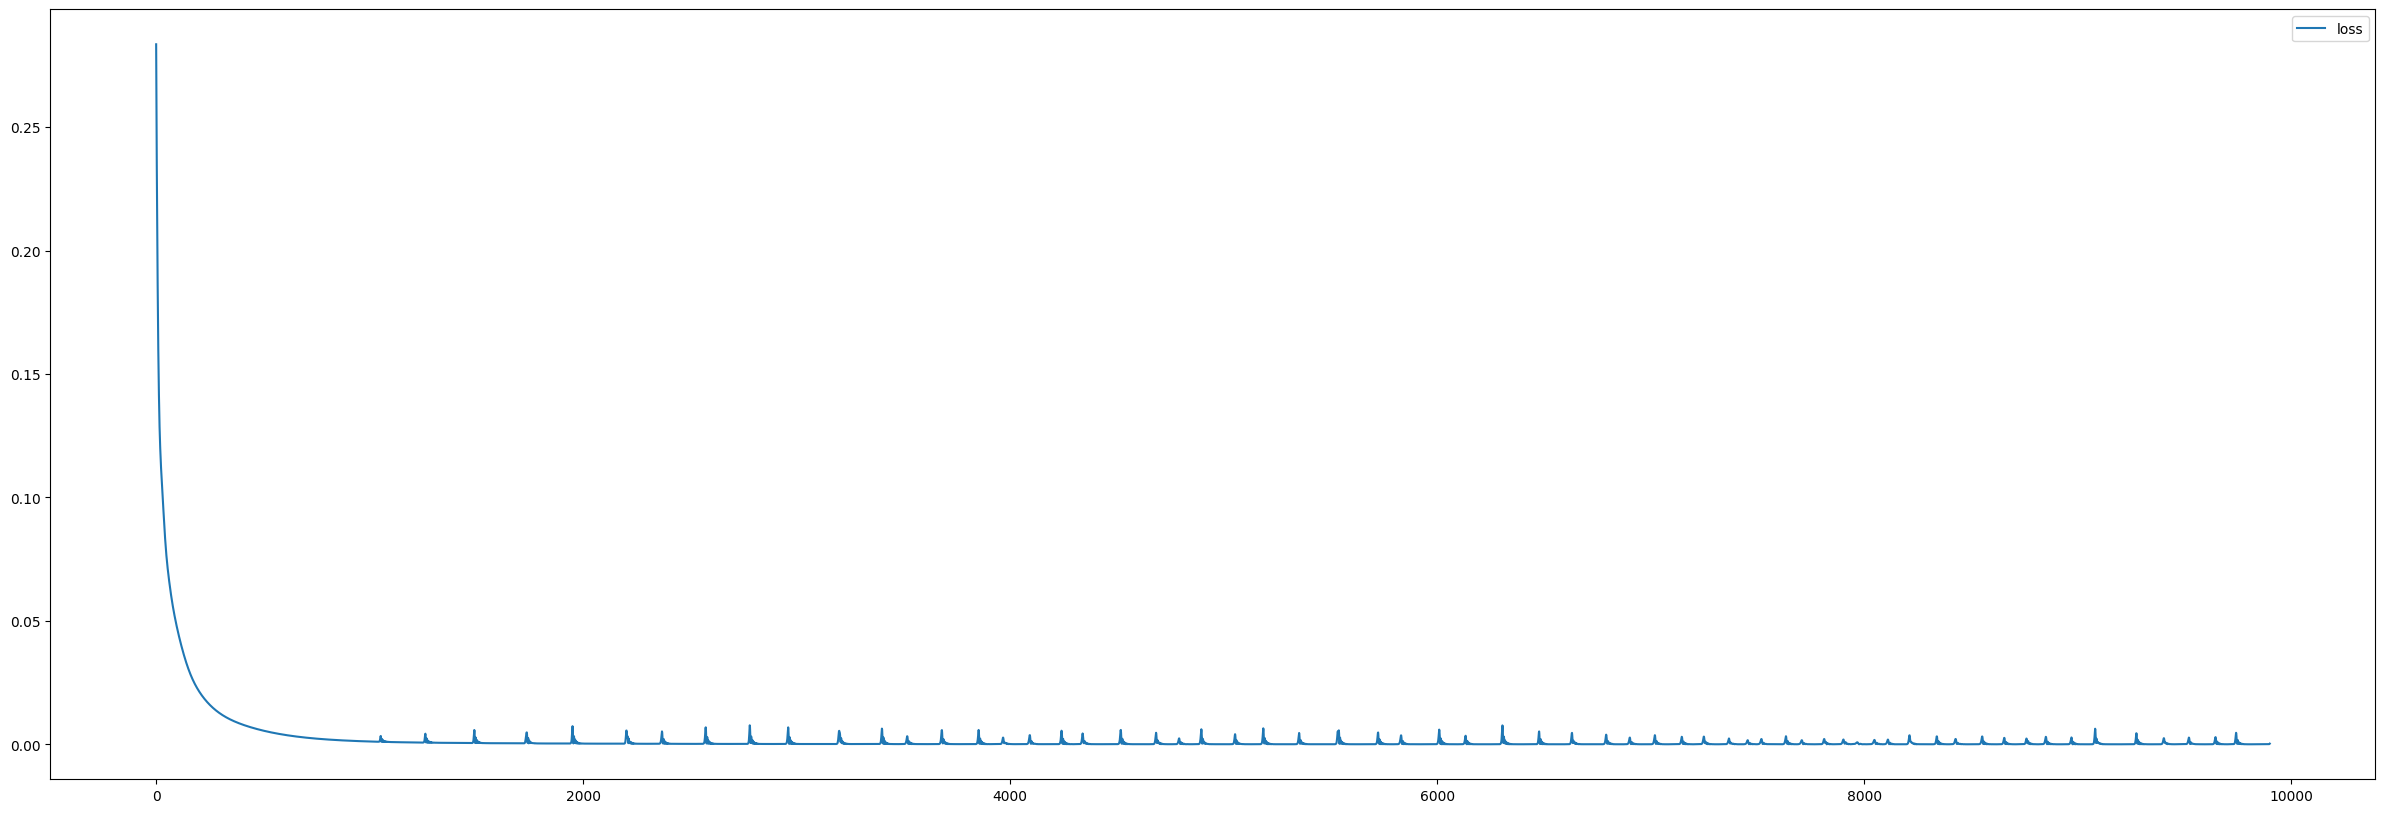

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(loss, label='loss')
plt.legend()
plt.show()

# Inference + Results

In [ ]:
checkpoint = torch.load("model.pth")
pinn.feed_forward.load_state_dict(checkpoint['model'])

# PINN inference
u_hat, gv_hat = pinn.predict(XT)

TOTAL INFERENCE TIME: 
00:00:00.00


<ipython-input-243-0f77bacde0be>:146: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(XT[:, 0], dtype=self.dtype, device=self.device, requires_grad=True).float()
<ipython-input-243-0f77bacde0be>:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(XT[:, 1], dtype=self.dtype, device=self.device, requires_grad=True).float()


In [ ]:
np.count_nonzero(np.isclose(np.abs(u - u_hat.flatten()), 0, atol=1e-3))

16325

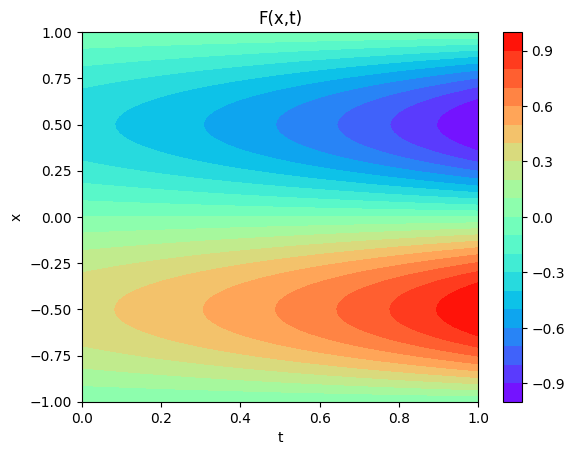

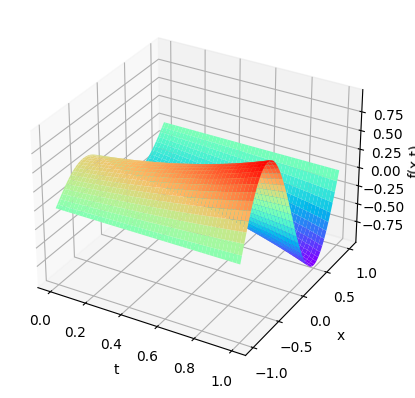

In [ ]:
plot3D(-x, torch.tensor(np.flip(t.numpy().flatten()).copy()).view(-1, 1), torch.tensor(u).view(N_X, N_T))

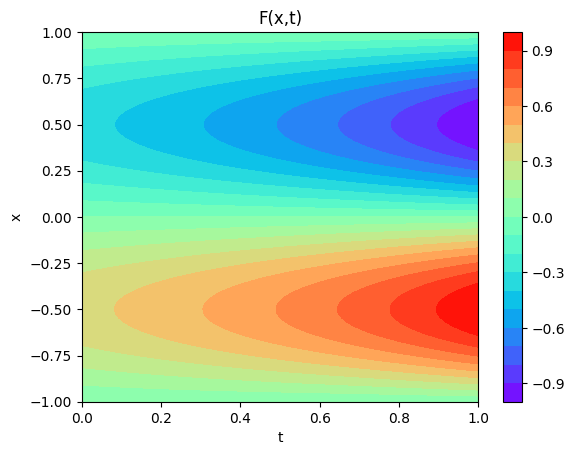

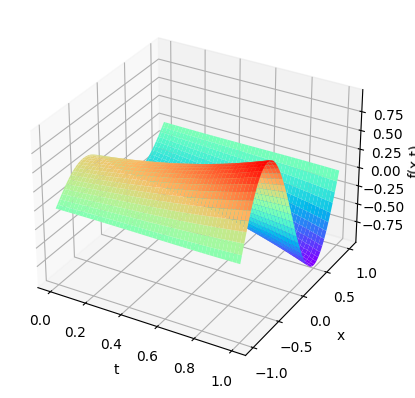

In [ ]:
plot3D(-x, torch.tensor(np.flip(t.numpy().flatten()).copy()).view(-1, 1), torch.tensor(u_hat).view(N_X, N_T))

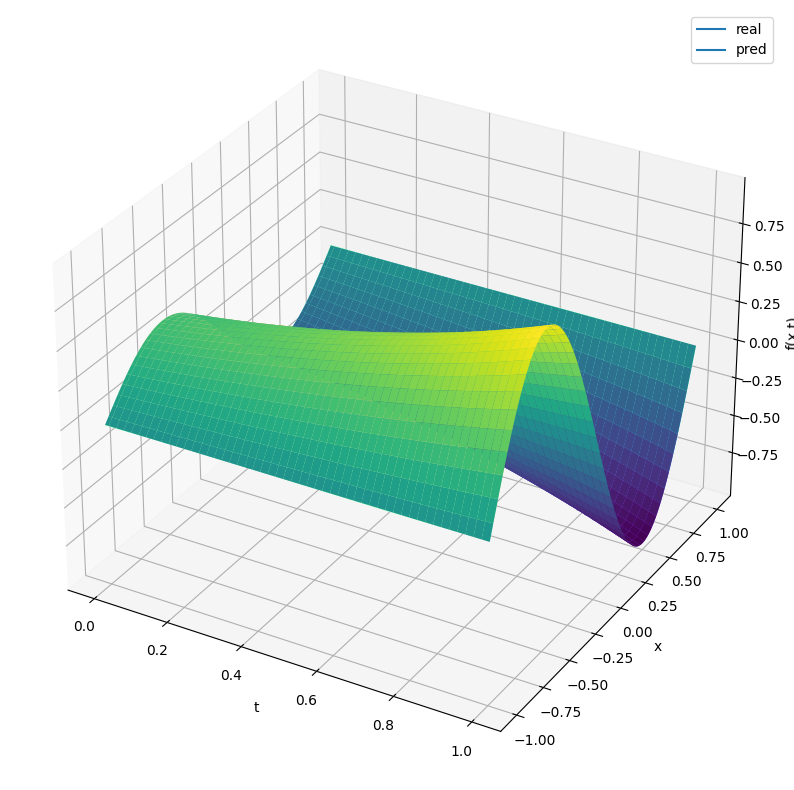

In [ ]:
plot3D_2(-x, torch.tensor(np.flip(t.numpy().flatten()).copy()).view(-1, 1), torch.tensor(u).view(N_X, N_T),
         -x, torch.tensor(np.flip(t.numpy().flatten()).copy()).view(-1, 1), torch.tensor(u_hat).view(N_X, N_T))

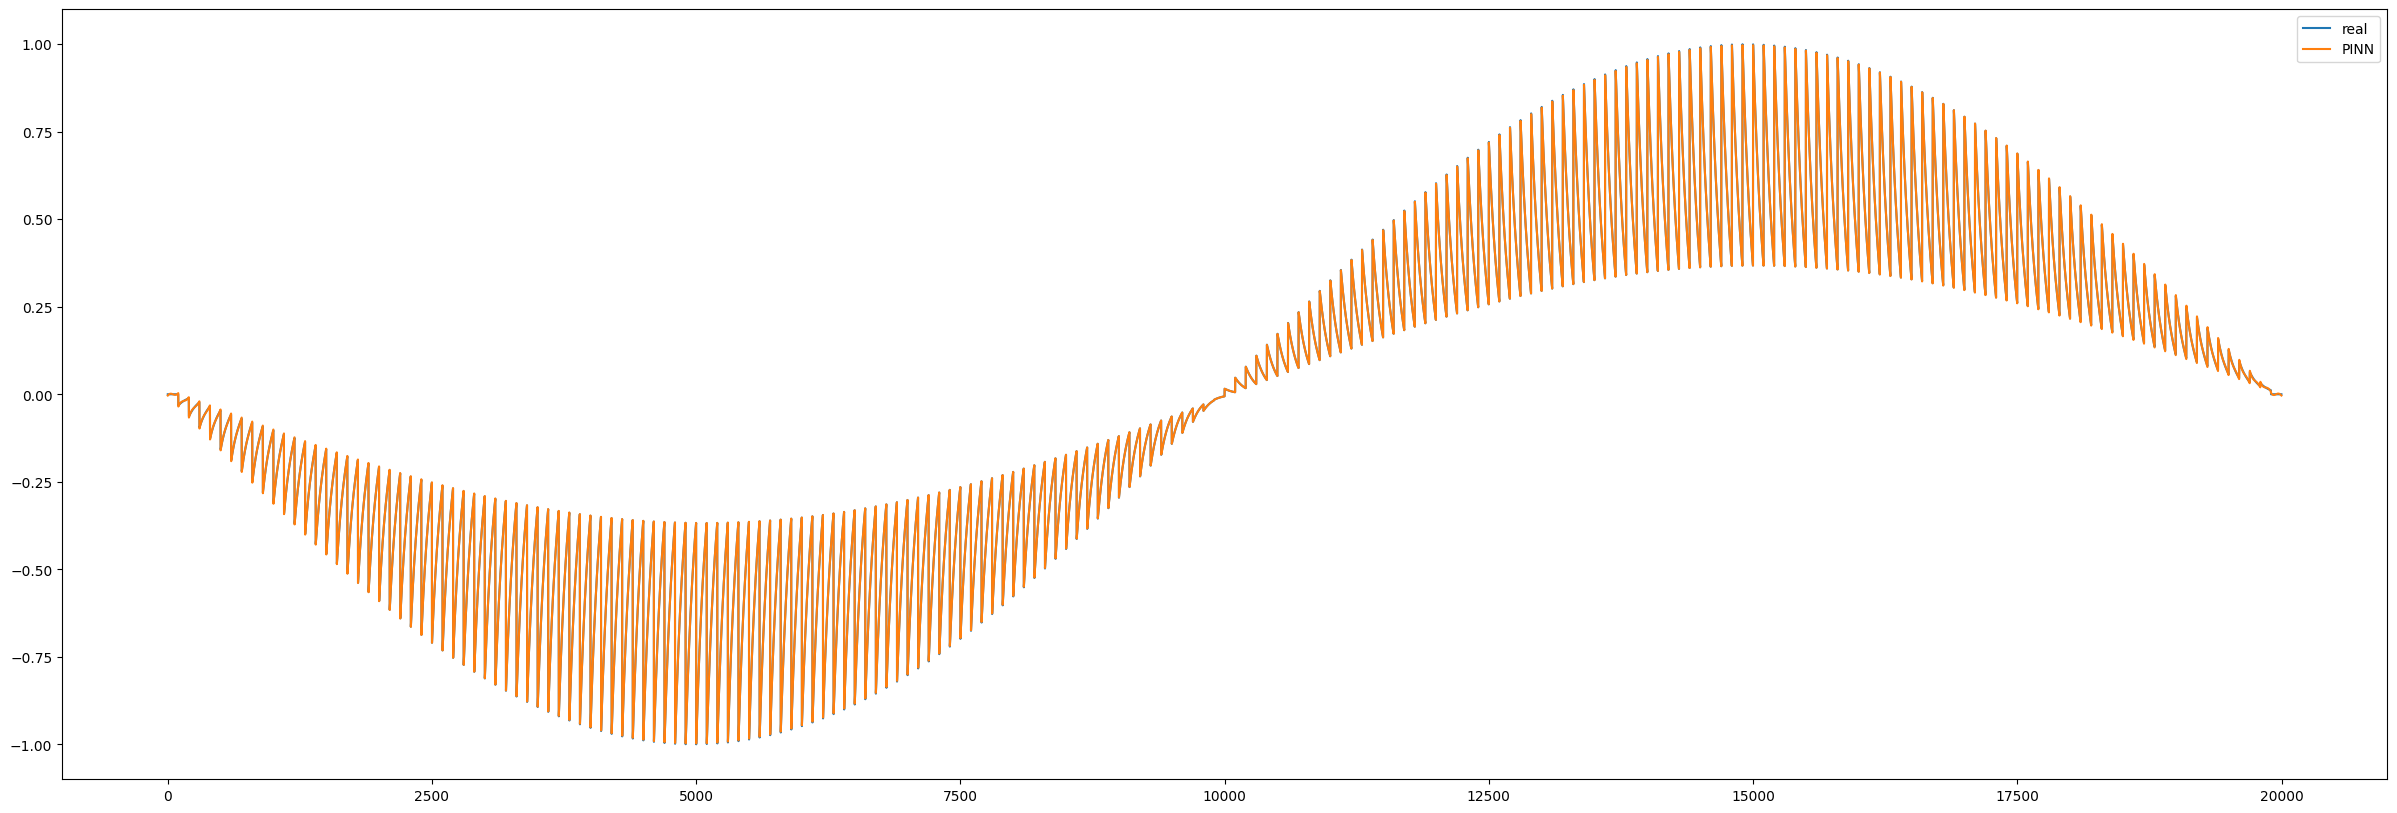

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(u, label='real')
plt.plot(u_hat, label='PINN')
plt.legend()
plt.show()